## Initial Data Visualization and Analysis

In [5]:
!pip install datasets==2.18.0


In [6]:
import sys 
import matplotlib.pyplot as plt
import pandas as pd 
import plotly.express as px
import json
import seaborn as sns
from datetime import datetime
from datasets import Dataset
from datasets import load_dataset

## Loading the data

In [7]:
data = pd.read_csv('data/final_dataset.csv')

## Scatter Plot to compare ratings of books and movies

In [8]:
fig = px.scatter(
    data,
    x='normalized_rating_x',
    y='normalized_rating_y',
    hover_name='movie_name',
    title='Movie Rating vs. Book Ratings',
    labels={'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'},
    template='plotly_white'
)

fig.update_layout(
    
    width=600, 
    height=600
)
fig.show()

One can see that most book and movie ratings are around 0.6 which is around 3 stars in the standard 5 star rating system. This seem very reasonable. Additionally, there seems to be a positive correlation between book and movie ratings, which was expected.

## Number of languages per movie

In [9]:
# Function to count languages
def count_languages(entry):
    languages_dict = json.loads(entry)
    return len(languages_dict)

# Apply the function to the DataFrame
data['language_count'] = data['language'].apply(count_languages)

filtered = data[data['language_count']>1]
filtered[['language', 'language_count']]
data = data[data['revenue'] != 0]
print(len(data))
fig = px.scatter(
    data,
    x='revenue',
    y='language_count',
    hover_name='movie_name',
    title='Revenue vs Language count',
    labels={'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_type="log",
    width=1000, 
    height=600
)
fig.show()

1845


Plotting the number of languages into which a movie has been translated is an easy measurement for budget and success. Here one can see that there are few movies that are translated into more than one other languages. There are some quite evident problems in the data that can be seen in this figure. Movies such as "Harry Potter", "The Hunger Games" and "Jurassic Parc" are apparently only available in one language. This is surely wrong, which means that some further preprocessing of the data is necessary if one wants to analyse languages.

### Book Length Distribution

In [10]:
unique_books = data[['length', 'book_id', 'BookTitle', 'Author', 'normalized_rating_y', 'BookYear', 'review_count']].drop_duplicates(subset='book_id')

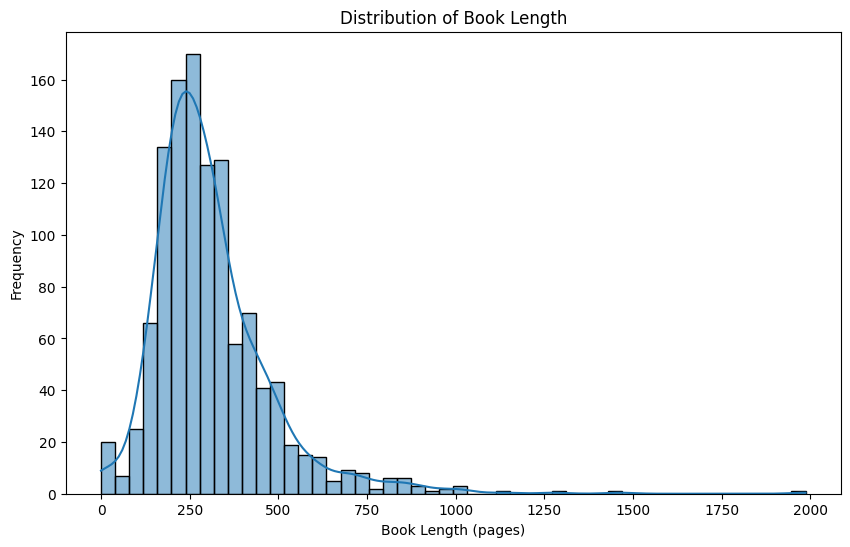

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(unique_books['length'], bins=50, kde=True)
plt.title('Distribution of Book Length')
plt.xlabel('Book Length (pages)')
plt.ylabel('Frequency')
plt.show()


This graph shows what one would expect, an average book is between 200 and 400 pages. This range is also present here which means that the data can be assumed correct on a first assumption.

## Comparison of Revenue with Book and Movie Ratings

In [12]:
df_revenue = data.dropna(subset=['revenue']).query('revenue != 0')
print(len(data), len(df_revenue))

1845 905


In [13]:
fig = px.scatter(
    df_revenue,
    x='revenue',
    y='normalized_rating_y',
    hover_name='movie_name',
    title='Revenue vs. Book Ratings',
    labels={'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_type="log",
    width=1000, 
    height=600
)
fig.show()

This plot shows the general behaviour that movie revenue is slightly correlated with the book ratings.

In [14]:
# We want to check which movies are successful based on the two characteristics revenue and movie ratings. We will show four quadrants each containing about a quarter of movies. 
def assign_quadrant(row, revenue_median, rating_median, revenue_column):
    if row[revenue_column] < revenue_median and row['normalized_rating_x'] < rating_median:
        return 'Low Rating & Low Revenue'
    elif row[revenue_column] < revenue_median and row['normalized_rating_x'] >= rating_median:
        return 'High Rating & Low Revenue'
    elif row[revenue_column] >= revenue_median and row['normalized_rating_x'] < rating_median:
        return 'Low Rating & High Revenue'
    else:
        return 'High Rating & High Revenue'
    

def quadrant_revenue(df_revenue, revenue_column, title):

    revenue_median = df_revenue[revenue_column].median()
    rating_median = df_revenue['normalized_rating_x'].median()

    df_revenue['Success Cathegory'] = df_revenue.apply(lambda row: assign_quadrant(row, revenue_median, rating_median, revenue_column), axis=1)

    fig = px.scatter(
        df_revenue,
        x=revenue_column,
        y='normalized_rating_x',
        hover_name='movie_name',
        color='Success Cathegory',
        title= title,
        labels={revenue_column: 'Movie Revenue ($), logscale', 'normalized_rating_x': 'Normalized Movie Rating'},
        template='plotly_white'
    )

    fig.add_shape(
        type='line',
        x0=revenue_median, x1=revenue_median,
        y0=df_revenue['normalized_rating_x'].min(), y1=df_revenue['normalized_rating_x'].max(),
        line=dict(color='Gray', width=1, dash="dash")
    )

    fig.add_shape(
        type='line',
        x0=df_revenue[revenue_column].min(), x1=df_revenue[revenue_column].max(),
        y0=rating_median, y1=rating_median,
        line=dict(color='Gray', width=1, dash="dash")
    )

    fig.update_layout(
        xaxis_type="log",
        width=1000,
        height=600
    )

    fig.show()

quadrant_revenue(df_revenue, 'revenue', title='Revenue vs. Movie Ratings')

The four categories that have been defined are dependend on the median movie ratings and the median movie revenues. This gives four categories of movies measured on the success metrics that were defined in the project description. There may be some essential differences between movies in the different quadrants of this plot that should be investigated further.

## Revenue Adaptation for inflation
We use the same approach as discussed in this article: https://towardsdatascience.com/adjusting-prices-for-inflation-in-pandas-daaaa782cd89 

We use the data from here: https://fred.stlouisfed.org/series/CPIAUCNS 

In [15]:
inflation = pd.read_csv('data/CPIAUCNS.csv', parse_dates=['DATE'])

inflation['Year'] = inflation['DATE'].dt.year

inflation_yearly = inflation.groupby('Year')['CPIAUCNS'].mean().reset_index()
inflation_yearly.columns = ['Year', 'CPI']

base_year = data.movie_year.max()
base_cpi = inflation_yearly[inflation_yearly['Year'] == base_year]['CPI'].values[0]

df_revenue = df_revenue.merge(inflation_yearly, left_on='movie_year', right_on='Year', how='left')


In [16]:

df_revenue['AdjustedRevenue'] = df_revenue['revenue'] * (base_cpi / df_revenue['CPI'])

fig = px.scatter(
    title="Original vs. Inflation-Adjusted Revenue (base year = 2013) of Movies"
)

fig.add_scatter(
    x=df_revenue['movie_year'],
    y=df_revenue['revenue'],
    mode='markers',
    name='Original Revenue',
    marker=dict(color='blue'),
    hovertext=df_revenue['BookTitle']
)

fig.add_scatter(
    x=df_revenue['movie_year'],
    y=df_revenue['AdjustedRevenue'],
    mode='markers',
    name='Adjusted Revenue',
    marker=dict(color='red'),
    hovertext=df_revenue['BookTitle']
)

fig.update_layout(
    xaxis=dict(title='Release Year'),
    yaxis=dict(type='log', title='Revenue (USD), log scale'),
    showlegend=True
)

fig.show()

With this inflation-adjustment trends can be visualized related to the cost of living at that momnent. This shows that the trend of increasing revenues is much less present than initially thought. Another thing that can be seen is the increase in movies at around 1980. After 1980 it seems that movies have a much harder time to make a lot of money. This may also arise because of a bias in the dataset which leads to only successful old movies being included.

## Let's plot the categories with Inflations-Adjustment

In [17]:
quadrant_revenue(df_revenue, 'AdjustedRevenue', title='Adjusted Revenue vs. Movie Ratings')

The inflation-adjustment has little impact on this particular plot. The main thing that can be seen is a shift to the right, so a general increase in revenues. Which comes from the fact that the inflation was adjusted to the value of today's money, rather than to the money from the past. 

## Top 10 Authors with the most different Books adapted into Movies

Text(0.5, 1.0, 'Top 10 Authors by Book Count')

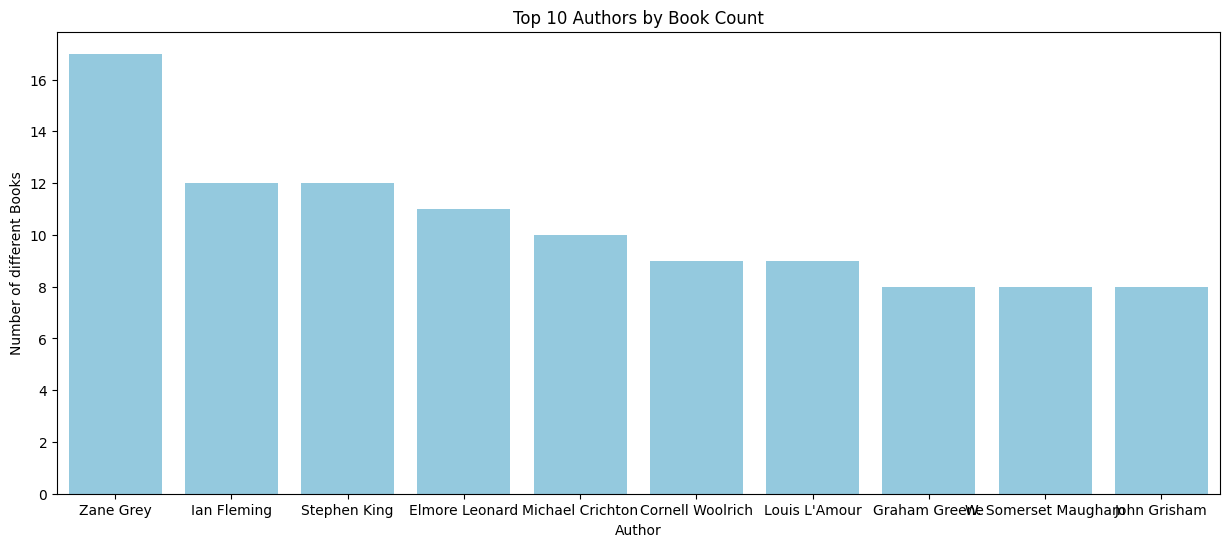

In [18]:
unique_books_author = unique_books[unique_books.Author != '0']
author_stats = unique_books_author.groupby('Author').agg(book_count=('BookTitle', 'size')).sort_values(by='book_count', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(15, 6))

sns.barplot(x=author_stats.index, y=author_stats['book_count'], color='skyblue', ax=ax1)
ax1.set_ylabel('Number of different Books')
ax1.set_xlabel('Author')
ax1.set_title('Top 10 Authors by Book Count')


Zane Grey seems to have understood the way of writing books that are later made into movies. While he is mainly known for western movies, Ian Fleming has gotten to his spot by writing all the "James Bond" books. Stephen King is on a well deserved third place with all of his horror movies. This plot shows, that most authors that write books which are adapted often, only write for a very specific niche. This is a sort of winner takes it all effect, which means that in some genres there is one author that will probably have all his books turned into films while most other authors are overlooked.

## Release Year of the Book

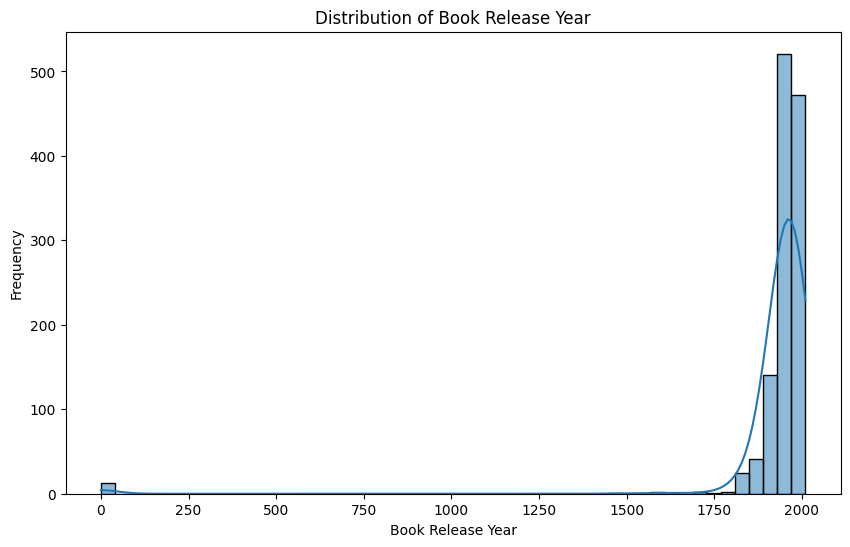

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(unique_books['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()


In [20]:
display(unique_books[unique_books.BookYear <= 50])

,length,book_id,BookTitle,Author,normalized_rating_y,BookYear,review_count
221,280.0,46437.0,Background to Danger,Eric Ambler,0.623333,0,72.0
270,320.0,13109354.0,One Thousand and One Nights,0,0.596667,0,211.0
596,541.0,1381.0,Odyssey,Homer,0.583333,0,9990.0
692,224.0,25309336.0,The Rebel Outlaw: Josey Wales,Asa Earl Carter,0.686667,0,52.0
718,181.0,162332.0,The Sailor Who Fell from Grace with the Sea,Yukio Mishima,0.630000,0,1047.0
1003,303.0,685970.0,"(1967), William Bradford Huie",0,0.450000,0,0.0
1115,272.0,58314.0,Les Particules Élémentaires,Michel Houellebecq,0.596667,0,1566.0
1357,283.0,4858198.0,A Job for Jenny,Faith Baldwin,0.466667,0,0.0
1370,213.0,52357.0,Beowulf,unknown,0.476667,0,5648.0
1385,132.0,747651.0,Biruma no tategoto,Michio Takeyama,0.560000,0,86.0


Some of these books are actually written a very long time ago (like Odyssey from Homer for example was written around 700 B.C.), but others just don't seem to have the correct year (like Background to Danger from 1937). Let's exclude them for now from the analysis, since they are only a few. 

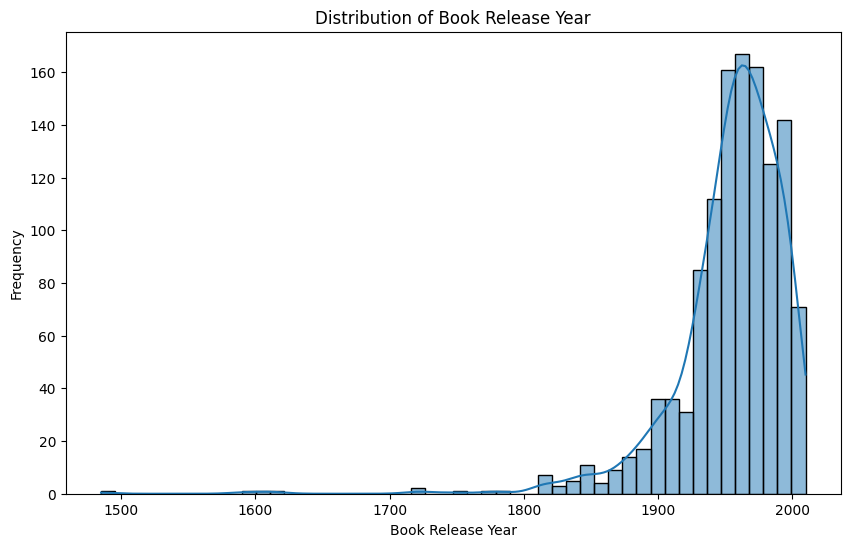

In [21]:
unique_books_year = unique_books[unique_books.BookYear != 0]
plt.figure(figsize=(10, 6))
sns.histplot(unique_books_year['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

Now the graph is more useful. Most books that were turned into movies were written in the 19th century. This mainly comes form an increase in book publishing since more people had the time and money to spend on writing. 

## How much time goes by between a Book and Movie Release?

In [22]:
year_book_movie = data.dropna(subset=['BookYear', 'movie_year'])
year_book_movie = year_book_movie[year_book_movie['BookYear']!=0]
year_book_movie['years_to_movie'] = year_book_movie['movie_year'] - year_book_movie['BookYear']

fig = px.scatter(
    year_book_movie,
    x='movie_year',
    y='years_to_movie',
    hover_data={'BookTitle': True, 'BookYear': True, 'movie_year': True, 'years_to_movie': True},
    title='Years Between Book and Movie Release',
    labels={'BookYear': 'Book Release Year', 'years_to_movie': 'Years to Movie Release'},
    template='plotly_white'
)

fig.update_traces(
    hovertemplate='<b>Book Title:</b> %{customdata[0]}<br>' +
                  '<b>Book Release Year:</b> %{customdata[1]}<br>' +
                  '<b>Movie Release Year:</b> %{x}<br>' +
                  '<b>Years to Movie Release:</b> %{y}<br>'
)

fig.show()


There seems to be something weird going on for the Tarzan movies... After some quick research, we found out that while in 1995 the last written work for a Tarzan novel was found, the original books were released much sooner. 

## Multiple Adaptations of the same book
For some Research Questions we will only look at Books that have been adapted into movies several times. We should identify them and see how many there are

In [23]:
book_adaptations = data.groupby(['book_id', 'BookTitle']).size().reset_index(name='adaptation_count')

# Sort by 'adaptation_count' in descending order to see the most frequently adapted books
book_adaptations = book_adaptations.sort_values(by='adaptation_count', ascending=False)

# Display the top books with the most adaptations
print(book_adaptations[book_adaptations.adaptation_count > 1])


         book_id                              BookTitle  adaptation_count
183      40425.0                                 Tarzan                39
1198  35031085.0                           Frankenstein                22
213      51499.0  Strange Case of Dr Jekyll and Mr Hyde                17
414     236093.0             The Wonderful Wizard of Oz                15
70        7190.0                Les Trois Mousquetaires                14
...          ...                                    ...               ...
772    1024939.0                       The Wheels Spins                 2
753     973972.0                           Lost Horizon                 2
107      14337.0                with a Perfect Stranger                 2
170      33549.0                      The Shrinking Man                 2
171      33553.0                       A Stir of Echoes                 2

[249 rows x 3 columns]


In [24]:
#Let's say we are only interested in books that have been adapted more than 5 times
top_adapted_books = book_adaptations[book_adaptations.adaptation_count > 5]

fig = px.bar(
    top_adapted_books,
    x='BookTitle',
    y='adaptation_count',
    title='Books adapted more than 5 times',
    labels={'BookTitle': 'Book Title', 'adaptation_count': 'Number of Adaptations'},
    template='plotly_white'
)

fig.update_traces(
    hovertemplate='<b>Book Title:</b> %{x}<br><b>Adaptation Count:</b> %{y}<extra></extra>'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


"Tarzan" has been adapted 39 times, "Frankenstein" 21 times. What makes these books such good candiates for movies? This is one of the questions that will hopefully be answered in the final Data Story. 

## Summary Similarity Distribution

In [25]:
nlp_df = load_dataset("ada-datadruids/bookfilm_summaries_with_similarity_and_sentiment")['train'].to_pandas()
nlp_df.head()

Generating train split: 0 examples [00:00, ? examples/s]

,movie_id,book_title,movie_name,book_summary,film_summary,similarity,film_sentiment,film_sentiment_score,book_sentiment,book_sentiment_score
0,196176,The Siege of Trencher's Farm,Straw Dogs,"George Magruder, an American professor of Eng...","David Sumner , a timid American mathematician,...",0.451876,positive,0.333608,positive,0.994480
1,6703617,Journey to the West,The Forbidden Kingdom,The novel has 100 chapters. These can be divi...,"In this film, which is based loosely on the an...",0.559594,positive,0.995482,positive,0.995404
2,24416479,The Beast Master,Beastmaster 2: Through the Portal of Time,"It tells the story of Hosteen Storm, an ex-so...","Dar, the Beastmaster , is back and now he has ...",0.344548,positive,0.997562,positive,0.998812
3,9384481,The Blessing,Count Your Blessings,It is set in the post-war World War II period...,While visiting Grace Allingham in wartime Lond...,0.669707,positive,0.996070,positive,0.996607
4,22224559,The Last Song,The Last Song,Veronica “Ronnie” Miller’s life was turned up...,"At seventeen, Veronica ""Ronnie"" Miller remain...",0.852735,positive,0.978184,positive,0.998164


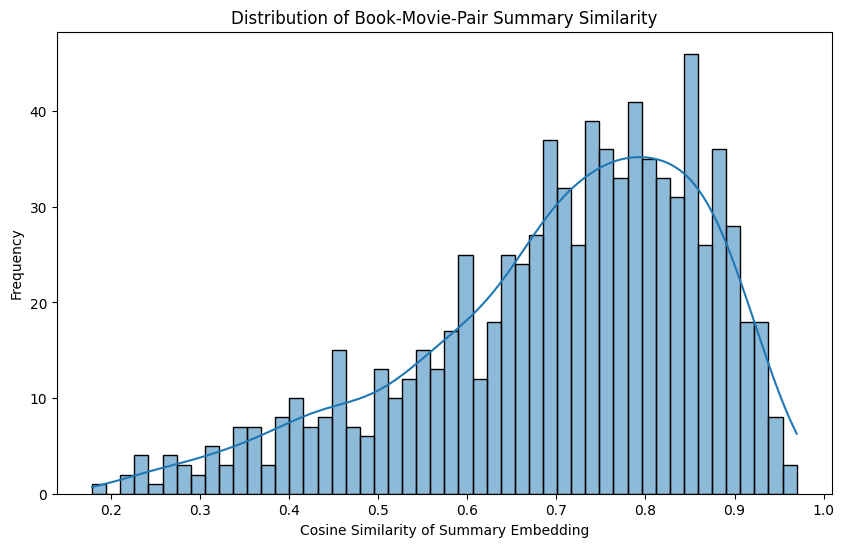

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(nlp_df['similarity'], bins=50, kde=True)
plt.title('Distribution of Book-Movie-Pair Summary Similarity')
plt.xlabel('Cosine Similarity of Summary Embedding')
plt.ylabel('Frequency')
plt.show()


The summary similarity between books and movies is quite high. There are however also quite a few summaries where the movie and book seem to differ a lot. Which of these movie-book pairs performed better or worse have not yet been analysed, but there will surely be some interesting conclusions to make.

## Sentiment Analysis

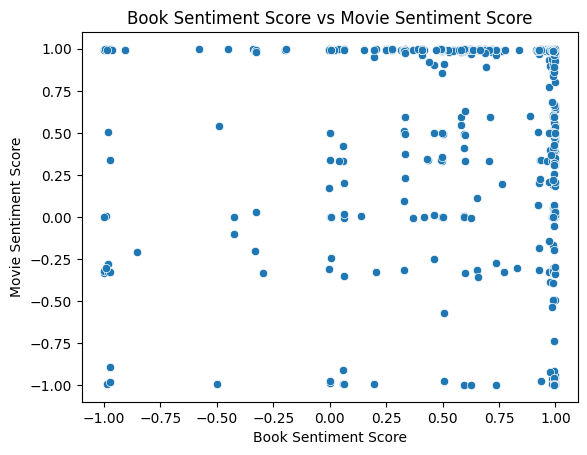

In [27]:
sns.scatterplot(x=nlp_df['book_sentiment_score'], y=nlp_df['film_sentiment_score'])

plt.xlabel('Book Sentiment Score')
plt.ylabel('Movie Sentiment Score')

plt.title('Book Sentiment Score vs Movie Sentiment Score')
plt.show()

This plot has no visual correlations between book and movie sentiment scores. One would expect to have quite a clear correlation of the movies were direct adaptations of the books, since this is not the case, some further investigation is needed.